### xgcm.diff详解
###### 13 August 2019 by MiniUFO

---
[TOC]

---

#### 1. 读取MITgcm模拟的温度数据和网格

C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along the dimensions None. Alternati

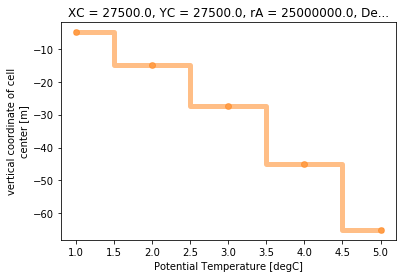

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xmitgcm
import xgcm
import xarray as xr

dset = xmitgcm.open_mdsdataset('H:/channel/', delta_t=300, prefix=['Stat'])

grid = xgcm.Grid(dset, periodic='XC')

T = dset['THETA'][0,:,5,5].where(dset['THETA'][0,:,5,5]!=0).load() # extract a temperature profile
T[:5] = np.array([1,2,3,4,5]) # asign the first five values so that the 1st difference is 1

T[:5].plot.step('C1o',y='Z', linewidth=5, where='mid', alpha=0.5)

#### 1. 一次差分（一阶导）
利用```grid.diff```计算温度的垂向差分，其中端点处的处理通过boundary关键字参数指定，分别为```'fill'```，```'extend'```，```'extrapolate'```三种。

从下图结果可以看到：
>```fill_value```参数只对```boundary='fill'```起作用，也即把给定的```fill_value=2```赋值给T的端点，然后再进行端点差分，结果是-1。

>```boundary='extend'```表示先将端点的T值扩展到外部，再进行差分。因此端点的差分结果永远是0。

>```boundary='extrapolate'```表示先通过外插把T的外部值插值出来，再进行差分，因此端点的差分结果和内区的第一个点一致。

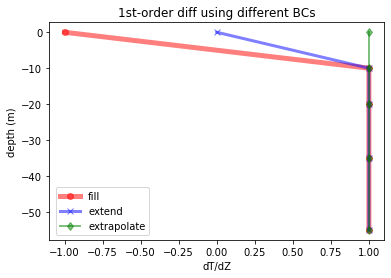

In [24]:
diffZ1 = grid.diff(T, 'Z',fill_value= 2, boundary='fill')
diffZ2 = grid.diff(T, 'Z',fill_value=60, boundary='extend')
diffZ3 = grid.diff(T, 'Z',fill_value=60, boundary='extrapolate')

plt.figure(1)
diffZ1[:5].plot.line('r-o', y='Zl', linewidth=5, alpha=0.5, label='fill')
diffZ2[:5].plot.line('b-x', y='Zl', linewidth=3, alpha=0.5, label='extend')
diffZ3[:5].plot.line('g-d', y='Zl', linewidth=2, alpha=0.5, label='extrapolate')

plt.xlabel('dT/dZ')
plt.ylabel('depth (m)')
plt.title('1st-order diff using different BCs')
plt.legend(loc=[0.02, 0.02])

#### 2. 二次差分（二阶导）

从下图两次差分的结果可以验证前面的结论。但是高阶倒数通过这样的方式计算似乎会产生位置的不断偏移，最好有直接的计算高阶倒数的函数，给定阶数参数即可。

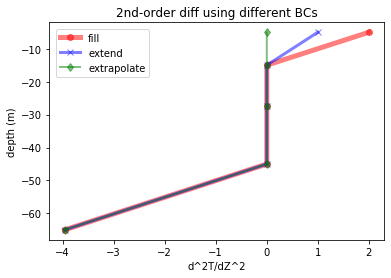

In [26]:
diff2Z1 = grid.diff(diffZ1, 'Z', fill_value= 2, boundary='fill')
diff2Z2 = grid.diff(diffZ2, 'Z', fill_value=60, boundary='extend')
diff2Z3 = grid.diff(diffZ3, 'Z', fill_value=60, boundary='extrapolate')

plt.figure(1)
diff2Z1[:5].plot.line('r-o', y='Z',linewidth=5, alpha=0.5, label='fill')
diff2Z2[:5].plot.line('b-x', y='Z',linewidth=3, alpha=0.5, label='extend')
diff2Z3[:5].plot.line('g-d', y='Z',linewidth=2, alpha=0.5, label='extrapolate')

plt.xlabel('d^2T/dZ^2')
plt.ylabel('depth (m)')

plt.title('2nd-order diff using different BCs')
plt.legend(loc=[0.02,0.75])

#### References
[https://xgcm.readthedocs.io/en/latest/api.html](https://xgcm.readthedocs.io/en/latest/api.html)